In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Importieren der CSV

In [120]:
track_data = pd.read_csv('Rohdaten_Stündlich_QB_2024_06_06.csv', sep = ';')

In [121]:
track_data.head(100)

,CustomIntervall,Unnamed: 1,linecount Zugang Europaviertel,linecount Bahnsteig01,linecount Bahnsteig02,linecount Bahnsteig03,linecount Bahnsteig04,linecount Bahnsteig05,linecount Bahnsteig06,linecount Bahnsteig07,...,STG_QB04_Steg01,STG_Bonatz10_Steg01,STG_QB12_Steg02,STG_Bonatz13_Steg02,STG_Bonatz04,linecount Zugang Infoturm Stuttgart,linecount Zugang Schlossgarten,(AB) linecount Zugang Schlossgarten+ITS,Bahnsteige Gesamt angepasst,Steg 02 Gesamt
0,01.01.2023 00:00,NaN,362,155,68,39,253,193,0,303,...,0,0,0,0,942,0,49,0,1.344,942.0
1,01.01.2023 01:00,NaN,482,251,94,108,550,138,0,406,...,0,0,0,0,874,6,71,0,1.979,874.0
2,01.01.2023 02:00,NaN,402,136,103,75,257,164,0,490,...,0,0,0,0,628,4,42,0,1.509,628.0
3,01.01.2023 03:00,NaN,363,144,109,89,356,97,0,222,...,0,0,0,0,611,2,45,0,1.304,611.0
4,01.01.2023 04:00,NaN,430,193,81,56,273,263,0,271,...,0,0,0,0,689,2,31,0,1.426,689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,04.01.2023 23:00,NaN,396,111,138,210,273,235,0,159,...,0,0,0,0,425,2,66,0,1.392,425.0
96,05.01.2023 00:00,NaN,210,42,12,12,73,156,0,110,...,0,0,0,0,270,0,19,0,598.000,270.0
97,05.01.2023 01:00,NaN,66,32,16,2,1,51,0,14,...,0,0,0,0,28,2,0,0,122.000,28.0
98,05.01.2023 02:00,NaN,101,34,10,9,6,124,0,5,...,0,0,0,0,58,2,7,0,201.000,58.0


# Filtern von nicht notwendigen Zeilen
Es ist für die Analyse nur der Zeitpunkt, sowie der Bahnsteig relevant. 

In [122]:
# Spaltennamen anzeigen
print(track_data.columns)

Index(['CustomIntervall', 'Unnamed: 1', ' linecount Zugang Europaviertel',
       ' linecount Bahnsteig01', ' linecount Bahnsteig02',
       ' linecount Bahnsteig03', ' linecount Bahnsteig04',
       ' linecount Bahnsteig05', ' linecount Bahnsteig06',
       ' linecount Bahnsteig07', ' linecount Bahnsteig08', ' Querbahnsteig',
       ' STG_QB04_Steg01', ' STG_Bonatz10_Steg01', ' STG_QB12_Steg02',
       ' STG_Bonatz13_Steg02', ' STG_Bonatz04',
       ' linecount Zugang Infoturm Stuttgart',
       ' linecount Zugang Schlossgarten',
       ' (AB) linecount Zugang Schlossgarten+ITS',
       'Bahnsteige Gesamt angepasst', 'Steg 02 Gesamt'],
      dtype='object')


In [123]:
# Auswahl der gewünschten Spalten anhand der tatsächlich vorhandenen Spaltennamen
selected_columns = ['CustomIntervall', ' linecount Bahnsteig01', ' linecount Bahnsteig02', ' linecount Bahnsteig03', ' linecount Bahnsteig04', ' linecount Bahnsteig05', ' linecount Bahnsteig07', ' linecount Bahnsteig08']
filtered_data = track_data[selected_columns].copy()  # Explizit eine Kopie erstellen

# Sicherstellen, dass das Datum korrekt als Datetime-Typ eingelesen wird
filtered_data['CustomIntervall'] = pd.to_datetime(filtered_data['CustomIntervall'], format='%d.%m.%Y %H:%M')
filtered_data.set_index('CustomIntervall', inplace=True)

# Das gefilterte DataFrame anzeigen
filtered_data.head(100)

,linecount Bahnsteig01,linecount Bahnsteig02,linecount Bahnsteig03,linecount Bahnsteig04,linecount Bahnsteig05,linecount Bahnsteig07,linecount Bahnsteig08
CustomIntervall,,,,,,,
2023-01-01 00:00:00,155,68,39,253,193,303,333
2023-01-01 01:00:00,251,94,108,550,138,406,432
2023-01-01 02:00:00,136,103,75,257,164,490,284
2023-01-01 03:00:00,144,109,89,356,97,222,287
2023-01-01 04:00:00,193,81,56,273,263,271,289
...,...,...,...,...,...,...,...
2023-01-04 23:00:00,111,138,210,273,235,159,266
2023-01-05 00:00:00,42,12,12,73,156,110,193
2023-01-05 01:00:00,32,16,2,1,51,14,6


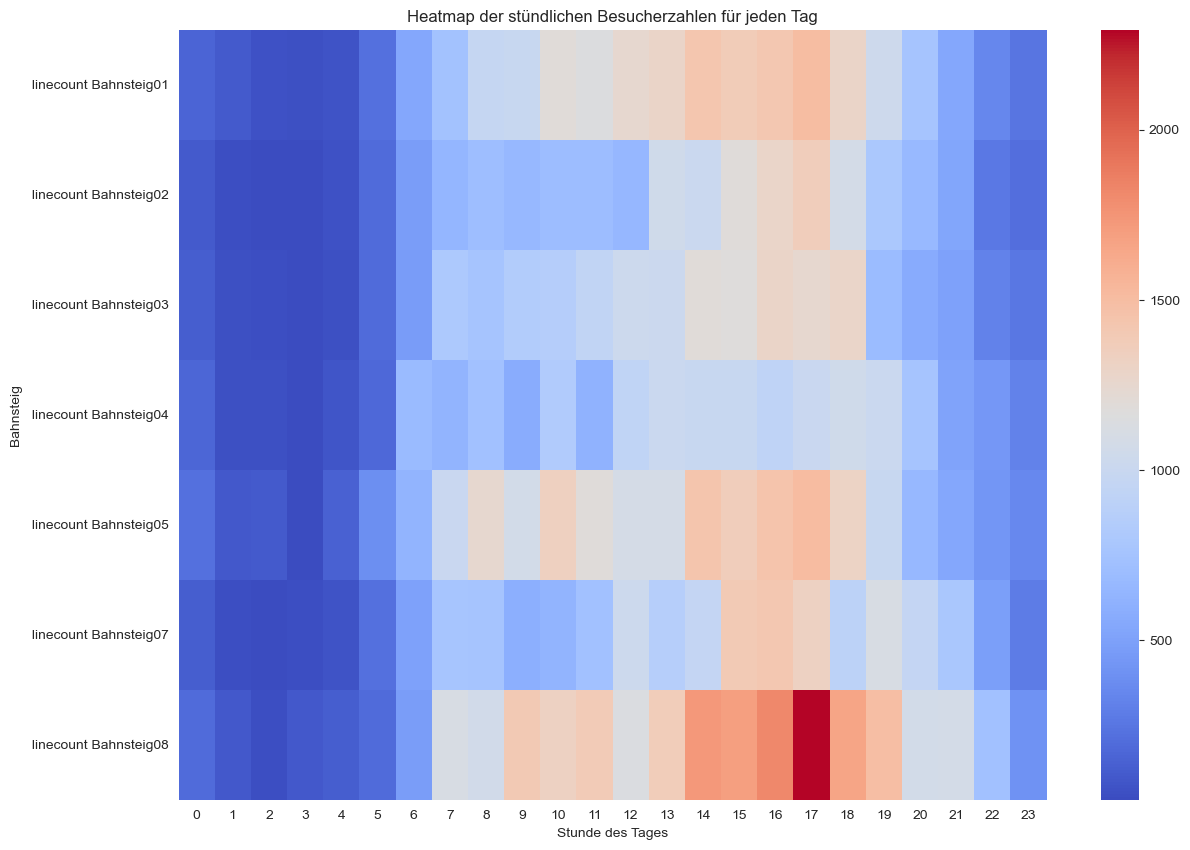

In [124]:
# Resampling der Daten, um stündliche Mittelwerte zu berechnen
hourly_data = filtered_data.resample('H').mean()

# Umstrukturieren der Daten für die Heatmap (Bahnsteige als Zeilen, Stunden als Spalten)
hourly_data_pivot = hourly_data.pivot_table(values=[' linecount Bahnsteig01', ' linecount Bahnsteig02', ' linecount Bahnsteig03', ' linecount Bahnsteig04', ' linecount Bahnsteig05', ' linecount Bahnsteig07', ' linecount Bahnsteig08'], index=hourly_data.index.hour)

# Erstellen der Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(hourly_data_pivot.T, cmap="coolwarm", annot=False)
plt.title('Heatmap der stündlichen Besucherzahlen für jeden Tag')
plt.xlabel('Stunde des Tages')
plt.ylabel('Bahnsteig')
plt.show()

### Wetterdaten analysieren und anpassen

In [125]:
# Wetterdaten laden und überprüfen
# Quelle: https://bulk.meteostat.net/v2/hourly/10738.csv.gz
wetterdaten = pd.read_csv('wetterdaten_stuttgart.csv', dayfirst=True, sep=',')
print("Wetterdaten Spalten:", wetterdaten.columns)

Wetterdaten Spalten: Index(['date', 'hour', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd',
       'wpgt', 'pres', 'tsun', 'coco'],
      dtype='object')


In [126]:
# Sicherstellen, dass die Spalte 'date' existiert und das Datum konvertieren
if 'date' in wetterdaten.columns:
    wetterdaten['date'] = pd.to_datetime(wetterdaten['date'])
else:
    raise KeyError("Die Spalte 'date' fehlt in der Wetter-CSV-Datei.")

# Spalten umbenennen und filtern
wetterdaten = wetterdaten[['date', 'temp', 'prcp', 'wspd']]
wetterdaten.columns = ['date', 'temperature', 'precipitation', 'wind_speed']

wetterdaten.head(24)

,date,temperature,precipitation,wind_speed
0,2023-01-01,9.4,0.0,3.6
1,2023-01-01,8.9,0.0,4.0
2,2023-01-01,13.1,0.0,3.2
3,2023-01-01,13.2,0.0,9.7
4,2023-01-01,13.9,0.0,12.2
5,2023-01-01,13.0,0.0,8.6
6,2023-01-01,11.9,0.0,6.8
7,2023-01-01,10.8,0.0,9.4
8,2023-01-01,11.2,0.0,7.9
9,2023-01-01,9.4,0.0,4.7


# Korrelationsanalyse
Durch eine Korrelationsmatrix lässt es sich nachvollziehen, inwiefern beide Datensätze zusammenhängen. Durch die Fusionierung kann man Die Datensätze besser verstehen.

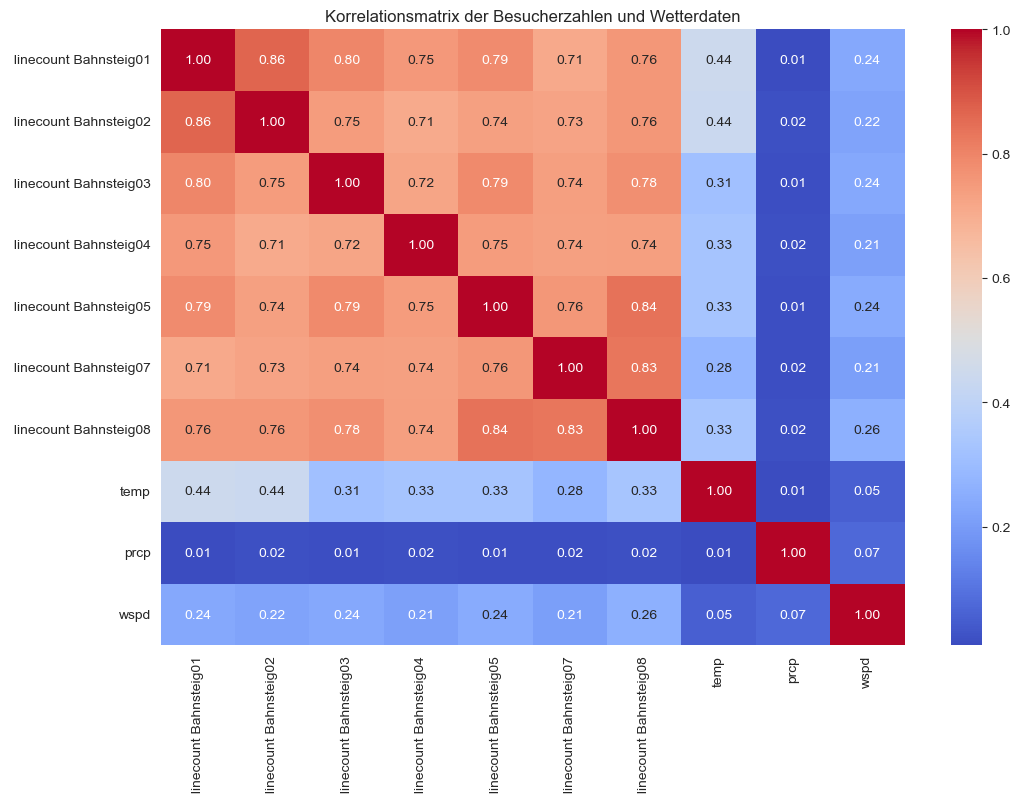

In [127]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Laden der Daten
track_data = pd.read_csv('Rohdaten_Stündlich_QB_2024_06_06.csv', sep=';')
weather_data = pd.read_csv('wetterdaten_stuttgart.csv', dayfirst=True, sep=',')

# Auswahl der gewünschten Spalten aus den Besucherdaten
selected_columns = [
    'CustomIntervall', ' linecount Bahnsteig01', ' linecount Bahnsteig02',
    ' linecount Bahnsteig03', ' linecount Bahnsteig04', ' linecount Bahnsteig05',
    ' linecount Bahnsteig07', ' linecount Bahnsteig08'
]
filtered_data = track_data[selected_columns].copy()

# Konvertieren des Datums in den Besucherdaten
filtered_data['CustomIntervall'] = pd.to_datetime(filtered_data['CustomIntervall'], format='%d.%m.%Y %H:%M')
filtered_data.set_index('CustomIntervall', inplace=True)

# Konvertieren des Datums in den Wetterdaten und Setzen des Index
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data.set_index(['date', 'hour'], inplace=True)

# Kombinieren der Daten basierend auf Datum und Stunde
combined_data = filtered_data.copy()
combined_data['hour'] = combined_data.index.hour
combined_data['date'] = combined_data.index.date
combined_data = combined_data.reset_index(drop=True)

# Zurücksetzen des Indexes in den Wetterdaten, um das Zusammenführen zu erleichtern
weather_data = weather_data.reset_index()

# Sicherstellen, dass 'hour' in beiden DataFrames als Integer und 'date' als Datetime vorliegen
combined_data['hour'] = combined_data['hour'].astype(int)
combined_data['date'] = pd.to_datetime(combined_data['date'])
weather_data['hour'] = weather_data['hour'].astype(int)
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Zusammenführen der Besucherdaten und Wetterdaten
combined_data = combined_data.merge(weather_data, how='left', left_on=['date', 'hour'], right_on=['date', 'hour'])

# Auswahl der relevanten Spalten für die Korrelationsanalyse
correlation_columns = [
    ' linecount Bahnsteig01', ' linecount Bahnsteig02', ' linecount Bahnsteig03',
    ' linecount Bahnsteig04', ' linecount Bahnsteig05', ' linecount Bahnsteig07',
    ' linecount Bahnsteig08', 'temp', 'prcp', 'wspd'
]

# Korrelationsmatrix berechnen
correlation_matrix = combined_data[correlation_columns].corr()

# Korrelationsmatrix darstellen
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korrelationsmatrix der Besucherzahlen und Wetterdaten')
plt.show()

Es fällt auf, dass eine hohe Korrelation zwischen den Bahnsteigen selber, jedoch eine etwas geringere Korrelation zwischen den Wetterbedingungen existieren. Jedoch bei der Temperatur fällt auf, dass ein Bahnsteig eine gewisse Abhängigkeit hat von der Temperatur hat. Dadurch müssen wir dies auch als Wert angeben, zum bestimmen der Besucherzahlen für unser Algorithmus.

# Die Funktion ermöglicht es, Besucherzahl anhand von einem Datensatz hervorzusagen
Es wird dafür nur ein Datum im Format "yyyy-mm-dd" benötigt. Es wird auch auf Schulferien und Feiertage geprüft.

### Definieren der Ferien

2024-05-30 00:00:00


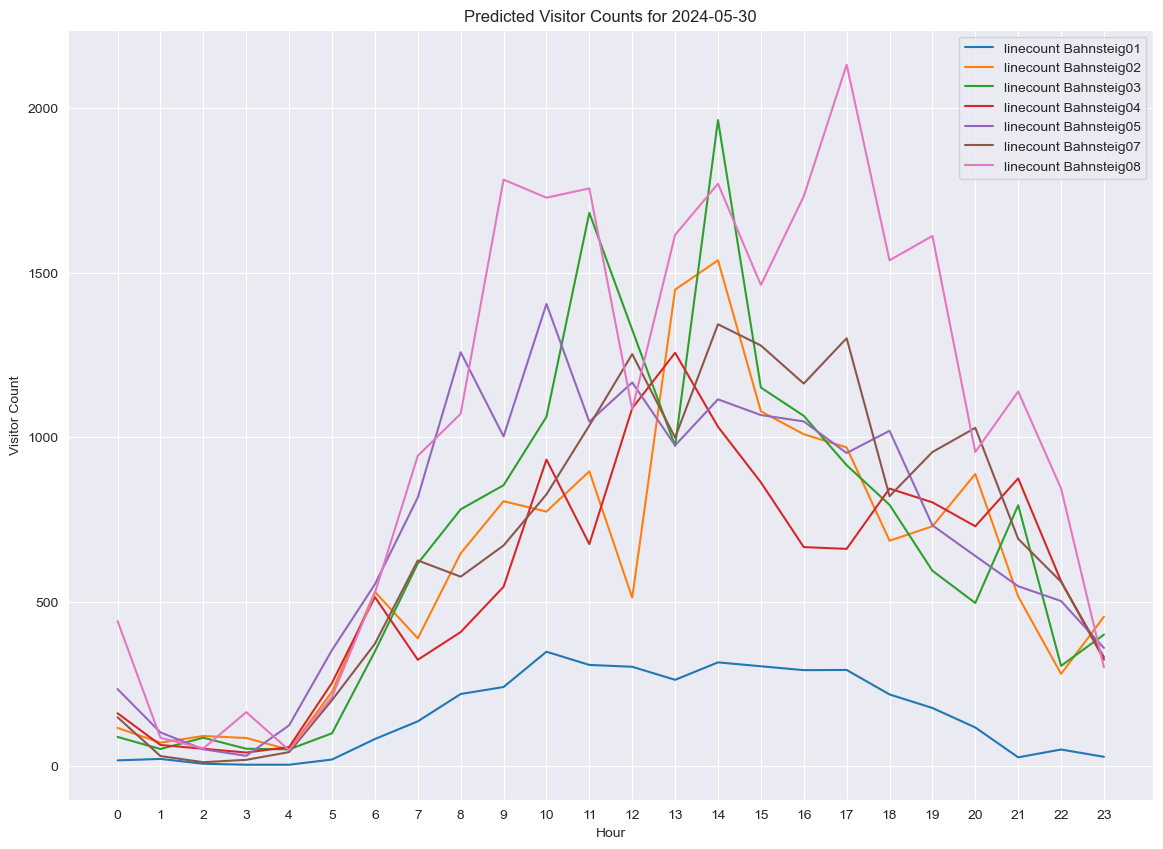

Evaluation for linecount Bahnsteig01:
  Mean Absolute Error (MAE): 47.50359972732377
  Mean Squared Error (MSE): 5390.173166268815
  R^2 Score: 0.9891766682747567
Evaluation for linecount Bahnsteig02:
  Mean Absolute Error (MAE): 53.81350707086909
  Mean Squared Error (MSE): 7341.211103288716
  R^2 Score: 0.9766922624114676
Evaluation for linecount Bahnsteig03:
  Mean Absolute Error (MAE): 66.49986149651134
  Mean Squared Error (MSE): 9757.680782438109
  R^2 Score: 0.9696085152642788
Evaluation for linecount Bahnsteig04:
  Mean Absolute Error (MAE): 57.03377465447643
  Mean Squared Error (MSE): 7577.920940642388
  R^2 Score: 0.9662907138037344
Evaluation for linecount Bahnsteig05:
  Mean Absolute Error (MAE): 58.624460154516534
  Mean Squared Error (MSE): 7405.365352116858
  R^2 Score: 0.9780906684540654
Evaluation for linecount Bahnsteig07:
  Mean Absolute Error (MAE): 54.47630857860828
  Mean Squared Error (MSE): 6835.126696295498
  R^2 Score: 0.9761165010114848
Evaluation for lineco

In [128]:
# Schulferien und Feiertage definieren
school_holidays = [
    ('2024-05-21', '2024-05-31'),
    ('2024-07-25', '2024-09-07'),
    ('2024-10-28', '2024-10-30'),
    ('2024-12-23', '2025-01-04')
]

public_holidays = [
    '2024-05-09', '2024-05-20', '2024-05-30', '2024-10-03',
    '2024-11-01', '2024-12-25', '2024-12-26'
]

# Konvertiere Feiertage zu Datetime
public_holidays = pd.to_datetime(public_holidays)

def is_holiday(date):
    return date in public_holidays

def is_school_holiday(date):
    for start, end in school_holidays:
        if start <= date.strftime('%Y-%m-%d') <= end:
            return True
    return False


def get_weather_features(date):
    weather = wetterdaten[wetterdaten['date'] == date]
    if not weather.empty:
        return weather.iloc[0][['temperature', 'precipitation', 'wind_speed']].to_dict()
    else:
        # Wenn keine Wetterdaten verfügbar sind, Standardwerte verwenden
        return {'temperature': 15, 'precipitation': 0, 'wind_speed': 5}

def predict_visitors(date_str):
    # Importieren der CSV-Datei
    track_data = pd.read_csv('Rohdaten_Stündlich_QB_2024_06_06.csv', sep=';')

    # Auswahl der gewünschten Spalten anhand der tatsächlich vorhandenen Spaltennamen
    selected_columns = ['CustomIntervall', ' linecount Bahnsteig01', ' linecount Bahnsteig02', ' linecount Bahnsteig03', ' linecount Bahnsteig04', ' linecount Bahnsteig05', ' linecount Bahnsteig06', ' linecount Bahnsteig07', ' linecount Bahnsteig08']
    filtered_data = track_data[selected_columns].copy()  # Explizit eine Kopie erstellen

    # Sicherstellen, dass das Datum korrekt als Datetime-Typ eingelesen wird
    filtered_data.columns = filtered_data.columns.str.strip()  # Entfernen von Leerzeichen aus Spaltennamen
    filtered_data['CustomIntervall'] = pd.to_datetime(filtered_data['CustomIntervall'], format='%d.%m.%Y %H:%M')

    # Extrahieren von Merkmalen aus dem Datum
    filtered_data['hour'] = filtered_data['CustomIntervall'].dt.hour
    filtered_data['day'] = filtered_data['CustomIntervall'].dt.day
    filtered_data['month'] = filtered_data['CustomIntervall'].dt.month
    filtered_data['weekday'] = filtered_data['CustomIntervall'].dt.weekday
    filtered_data['is_holiday'] = filtered_data['CustomIntervall'].dt.date.apply(lambda x: is_holiday(pd.to_datetime(x)))
    filtered_data['is_school_holiday'] = filtered_data['CustomIntervall'].dt.date.apply(lambda x: is_school_holiday(pd.to_datetime(x)))
    filtered_data['temperature'] = filtered_data['CustomIntervall'].dt.date.apply(lambda x: get_weather_features(pd.to_datetime(x))['temperature'])
    filtered_data['precipitation'] = filtered_data['CustomIntervall'].dt.date.apply(lambda x: get_weather_features(pd.to_datetime(x))['precipitation'])
    filtered_data['wind_speed'] = filtered_data['CustomIntervall'].dt.date.apply(lambda x: get_weather_features(pd.to_datetime(x))['wind_speed'])

    # Zielvariable (zum Beispiel Besucherzahlen auf Bahnsteig 1-8)
    targets = ['linecount Bahnsteig01', 'linecount Bahnsteig02', 'linecount Bahnsteig03', 'linecount Bahnsteig04', 'linecount Bahnsteig05', 'linecount Bahnsteig07', 'linecount Bahnsteig08']

    # Features definieren
    X = filtered_data[['hour', 'day', 'month', 'weekday', 'is_holiday', 'is_school_holiday', 'temperature', 'precipitation', 'wind_speed']]
    
    # Random Forest Regressor Modell trainieren für jeden Bahnsteig
    models = {}
    for target in targets:
        y = filtered_data[target]
        rf = RandomForestRegressor(n_estimators=100, random_state=random.randint(0,100))
        rf.fit(X, y)
        models[target] = rf

    # Daten für den angegebenen Tag erstellen
    pred_date = pd.to_datetime(date_str, format='%Y-%m-%d')
    weather_features = get_weather_features(pred_date)
    pred_data = pd.DataFrame({
        'hour': range(24),
        'day': [pred_date.day] * 24,
        'month': [pred_date.month] * 24,
        'weekday': [pred_date.weekday()] * 24,
        'is_holiday': [is_holiday(pred_date)] * 24,
        'is_school_holiday': [is_school_holiday(pred_date)] * 24,
        'temperature': [weather_features['temperature']] * 24,
        'precipitation': [weather_features['precipitation']] * 24,
        'wind_speed': [weather_features['wind_speed']] * 24
    })

    # Vorhersagen machen
    predictions = {}
    for target in targets:
        model = models[target]
        predictions[target] = model.predict(pred_data)

    print(pred_date)
    # Vorhersagen visualisieren
    plt.figure(figsize=(14, 10))
    for target in targets:
        plt.plot(range(24), predictions[target], label=target)
    plt.xticks(range(24))  # Setzt x-Achsenbeschriftungen auf jede Stunde
    plt.legend()
    plt.title(f'Predicted Visitor Counts for {date_str}')
    plt.xlabel('Hour')
    plt.ylabel('Visitor Count')
    plt.grid(True)  # Fügt ein Raster hinzu, um die Ablesbarkeit zu verbessern
    plt.show()

    return predictions, models, X, filtered_data[targets]

def evaluate_model(models, X, y_true):
    results = {}
    for target, model in models.items():
        y_pred = model.predict(X)
        mae = mean_absolute_error(y_true[target], y_pred)
        mse = mean_squared_error(y_true[target], y_pred)
        r2 = r2_score(y_true[target], y_pred)
        results[target] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    return results

# Beispielaufruf der Funktion
date_str = '2024-05-30'
predictions, models, X, y_true = predict_visitors(date_str)
evaluation_results = evaluate_model(models, X, y_true)

# Ergebnisse der Modellbewertung ausgeben
for target, metrics in evaluation_results.items():
    print(f"Evaluation for {target}:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']}")
    print(f"  Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"  R^2 Score: {metrics['R2']}")

Der R^2 Score zeigt, dass die KI eine sehr hohe Genauigkeit **1 ist sehr gut und 0 ist sehr schlecht** hat mit der Vorhersage.